Database 5: Data Fitting
========================

In this tutorial, we use the aggregator to load models and data from a non-linear search and use them to perform
fits to the data.

It is here the use of generators is absolutely essential. We are going to manipulating datasets which use a lot of
memory.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


First, set up the aggregator as we did in the previous tutorial.

In [2]:
# from autofit.database.aggregator import Aggregator
# database_file = path.join("output", "database", "database.sqlite")
# agg = Aggregator.from_database(path.join(database_file))
agg = af.Aggregator(directory=path.join("output", "database"))

Aggregator loading search_outputs... could take some time.

 A total of 3 search_outputs and results were found.


We can also use the aggregator to load the dataset of every lens our search fitted. This generator returns the 
the `Imaging` objects that we passed to the `Analysis` class when we performed the model-fit.

Datasets:



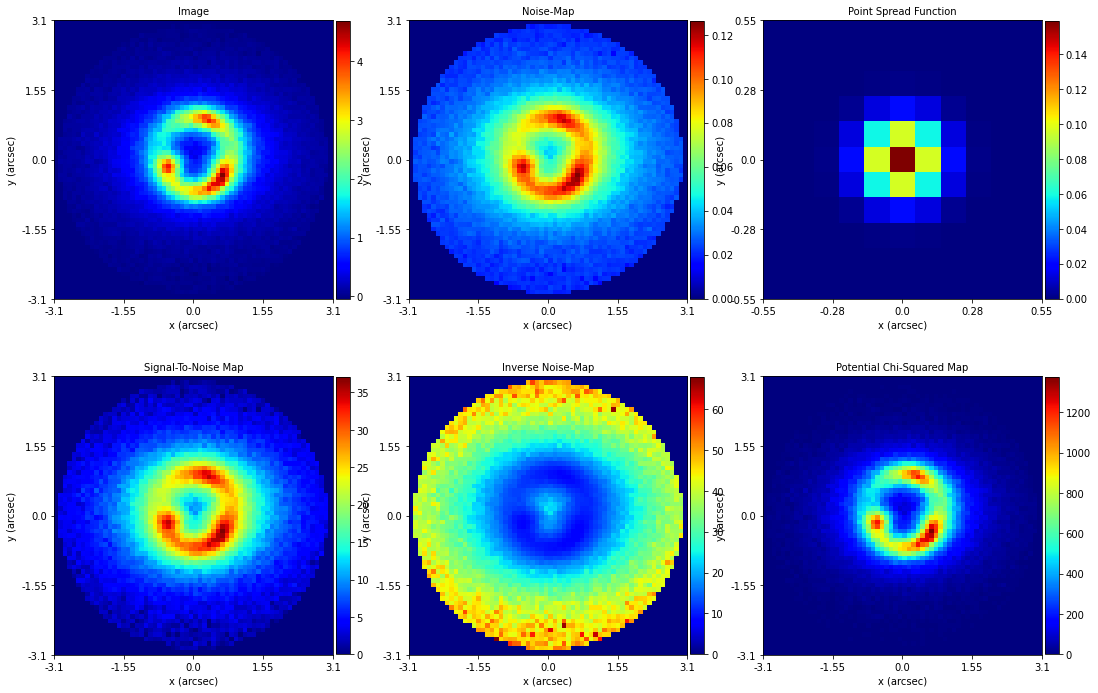

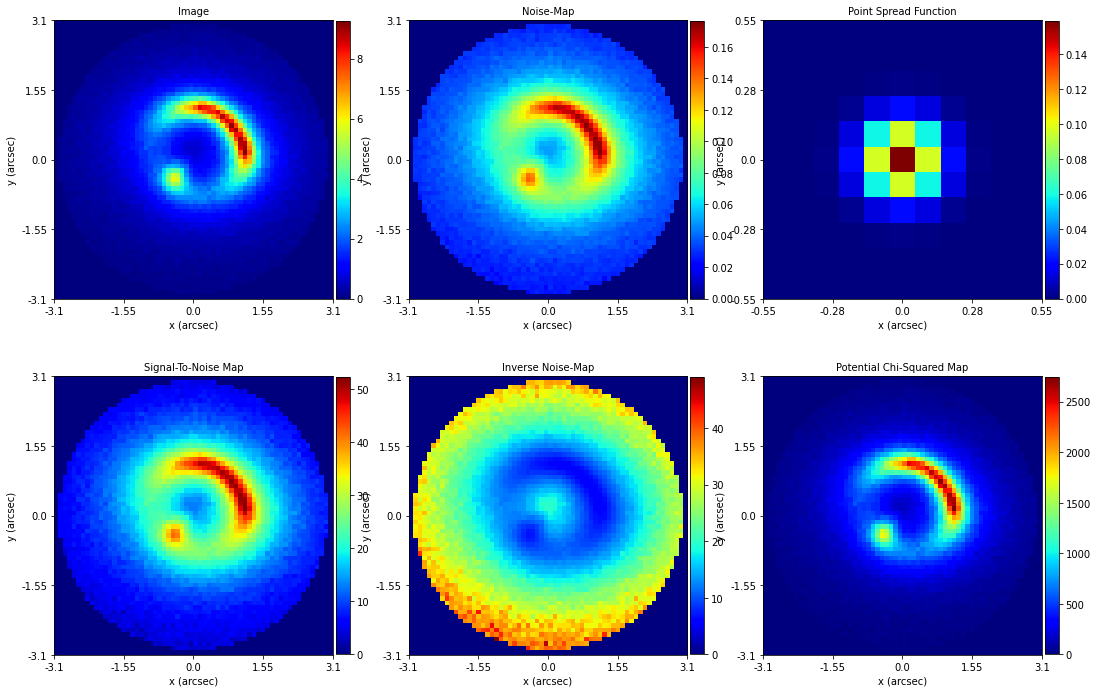

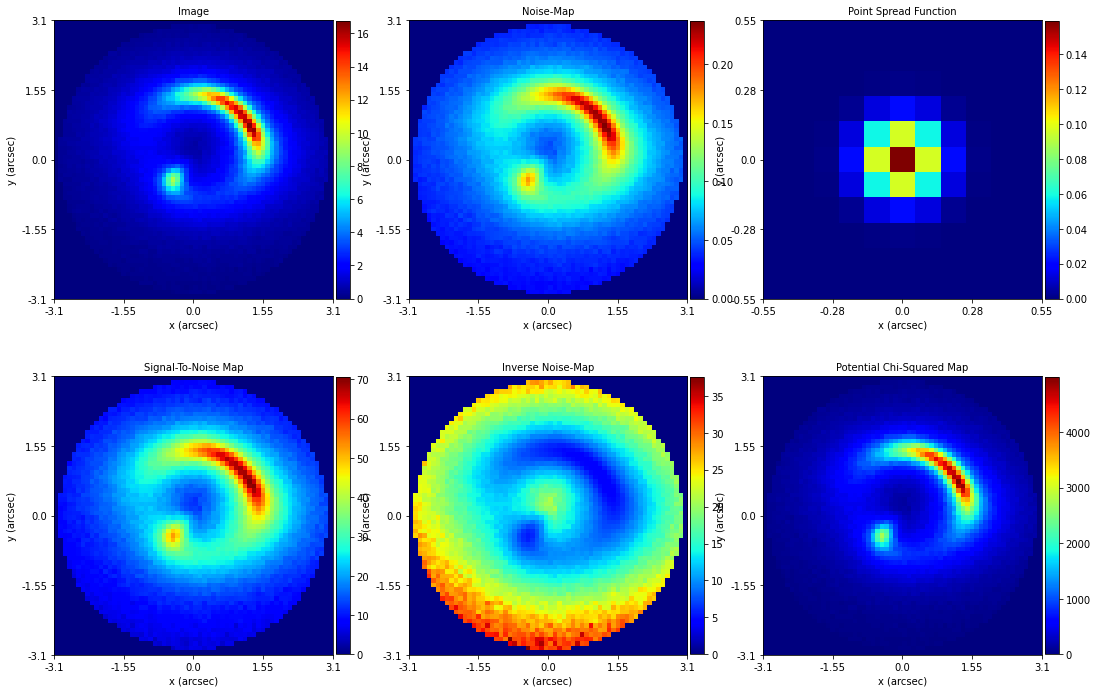

In [3]:
dataset_gen = agg.values("dataset")

print("Datasets:")
print(dataset_gen, "\n")
print(list(dataset_gen)[0])

for dataset in agg.values("dataset"):

    imaging_plotter = aplt.ImagingPlotter(imaging=dataset)
    imaging_plotter.subplot_imaging()

The masks we used to fit the lenses is contained in this `Imaging` object too.

In [4]:
mask_gen = agg.values("mask")
print([dataset.mask for dataset in dataset_gen])

[]


The name of the dataset we assigned when we ran the search is also available, which helps us to label the lenses 
on plots.

In [5]:
print("Dataset Names:")
dataset_gen = agg.values("dataset")
print([dataset.name for dataset in dataset_gen])

Dataset Names:
['mass_sie__source_sersic__0', 'mass_sie__source_sersic__1', 'mass_sie__source_sersic__2']


The info dictionary we passed is also available.

In [6]:
print("Info:")
info_gen = agg.values("info")
print([info for info in info_gen])

Info:
[{'redshihft_lens': 0.5, 'setup.redshift_source': 1.0, 'velocity_dispersion': 250000, 'stellar mass': 100000000000.0}, {'redshihft_lens': 0.75, 'setup.redshift_source': 2.0, 'velocity_dispersion': 200000, 'stellar mass': 500000000000.0}, {'redshihft_lens': 0.25, 'setup.redshift_source': 1.2, 'velocity_dispersion': 250000, 'stellar mass': 100000000000.0}]


We now have access to the `Imaging` data we used to perform a model-fit, and the results of that model-fit in the form
of a `Samples` object. 

We can therefore use the database to create a `FitImaging` of the maximum log-likelihood model of every model to its
corresponding dataset, via the following generator:

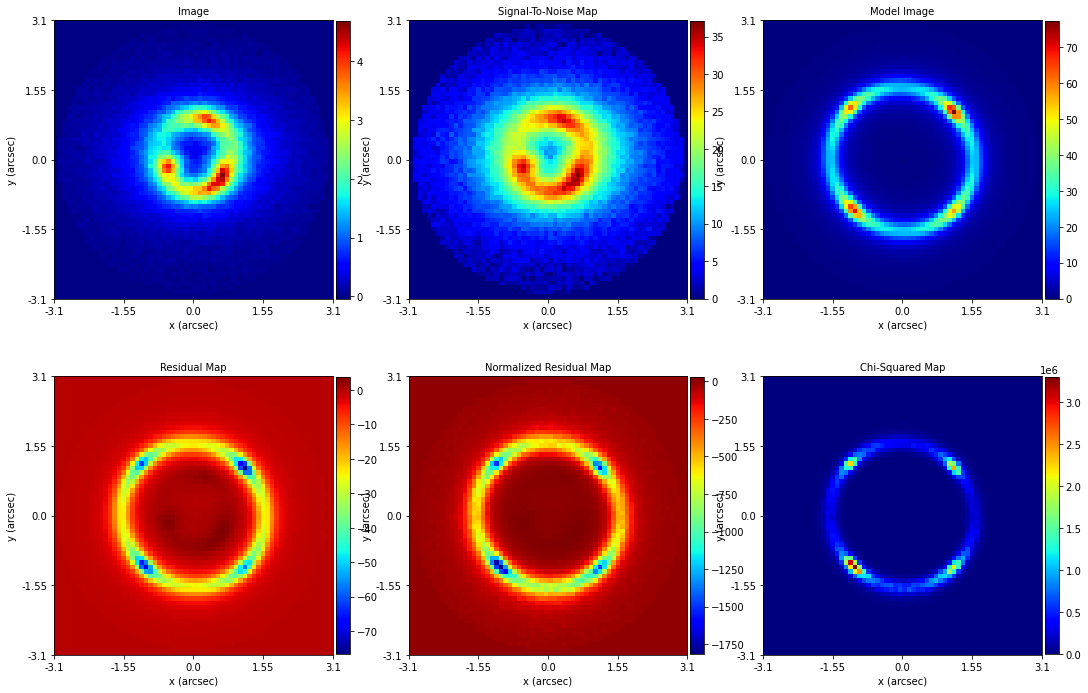

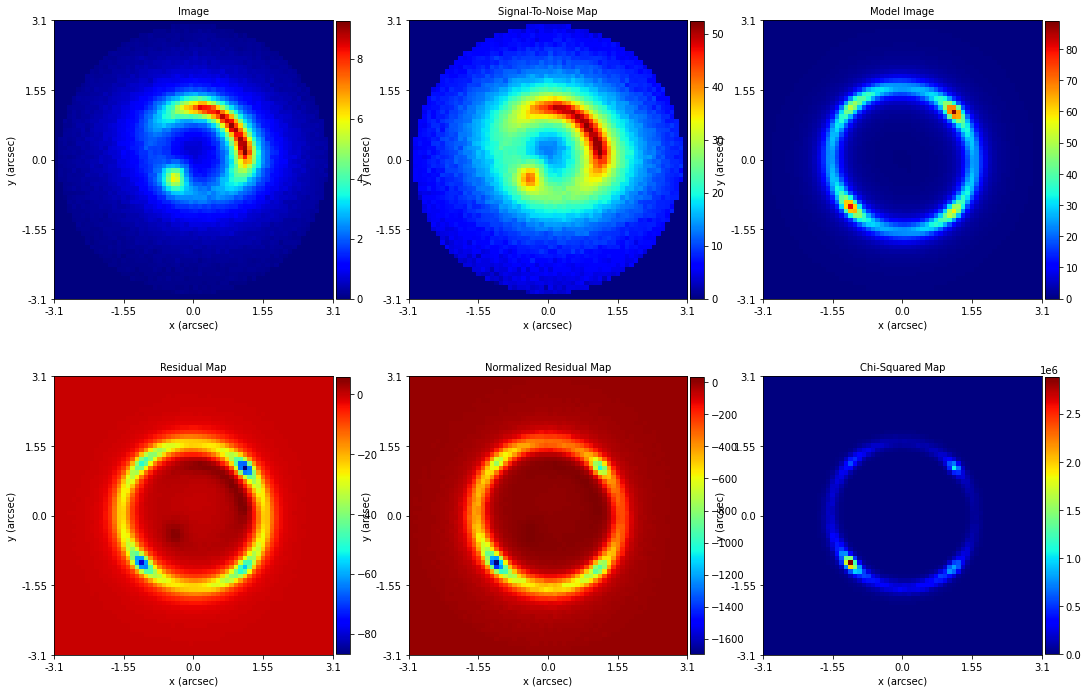

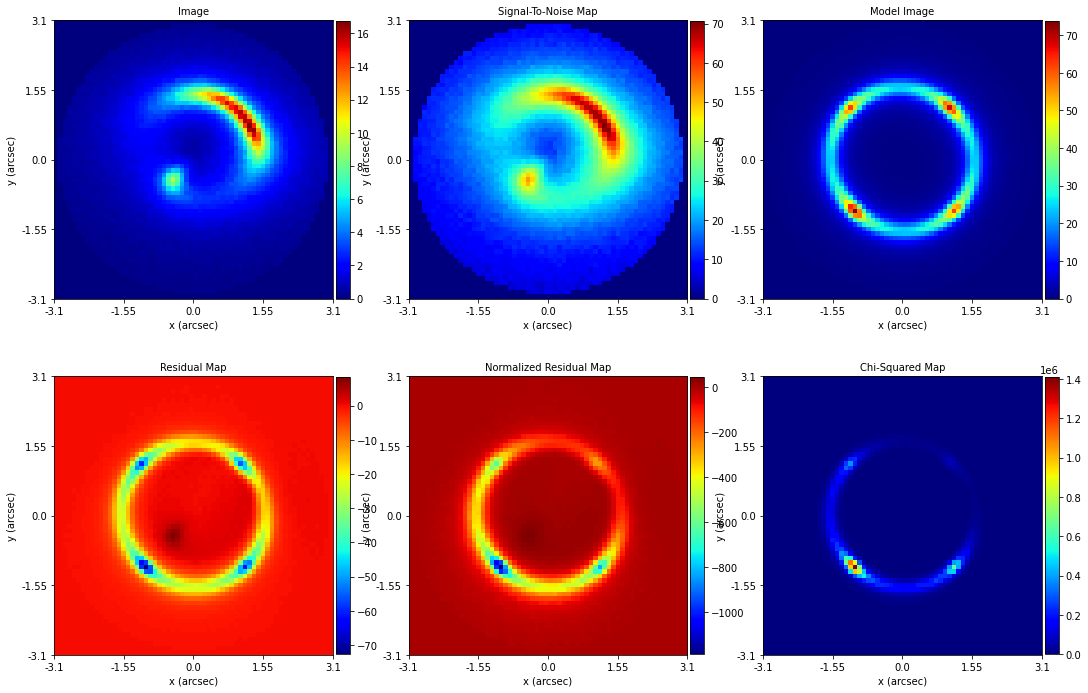

In [7]:


def make_fit_generator(agg_obj):

    samples = agg_obj.samples
    imaging = agg_obj.dataset

    tracer = al.Tracer.from_galaxies(
        galaxies=samples.max_log_likelihood_instance.galaxies
    )

    return al.FitImaging(imaging=imaging, tracer=tracer)


fit_gen = agg.map(func=make_fit_generator)

for fit in fit_gen:

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

The `AnalysisImaging` object has `settings_pixelization` and `settings_inversion` attributes, which customizes how 
these are used to fit the data. The generator above uses the `settings` of the object that were used by the model-fit. 

These settings objected are contained in the database and can therefore also be passed to the `FitImaging`.

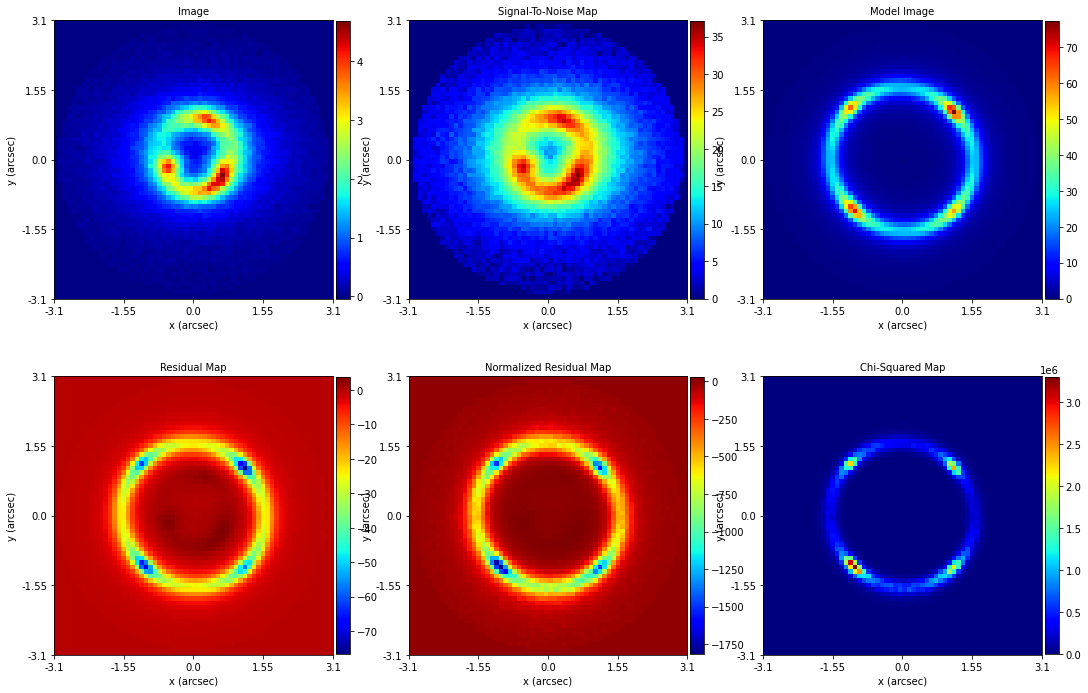

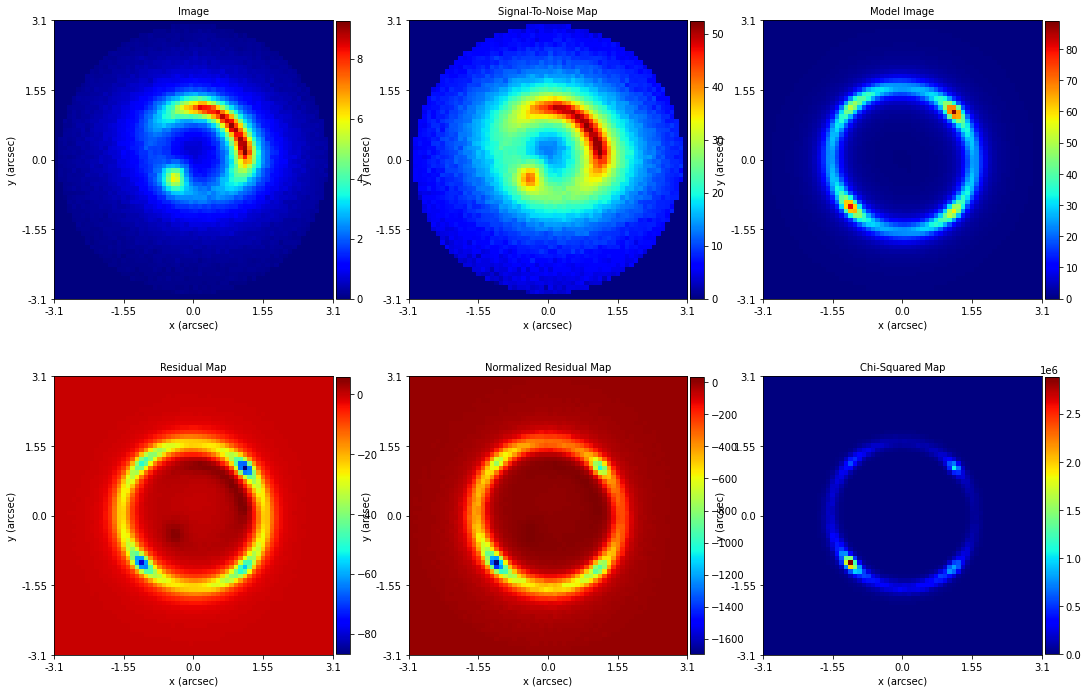

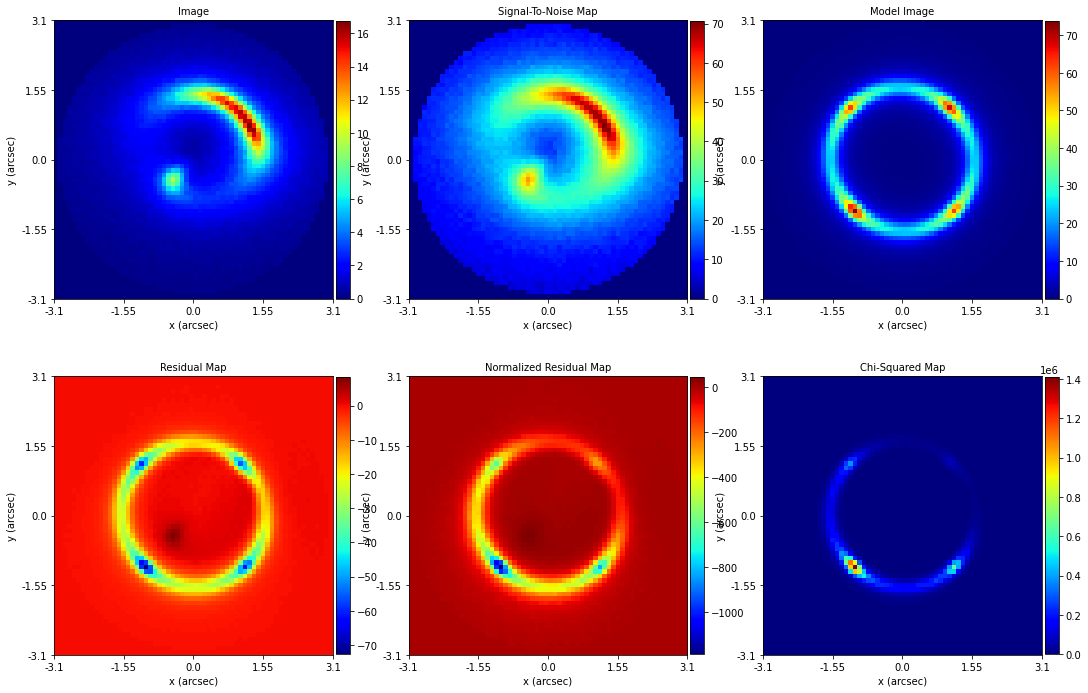

In [8]:


def make_fit_generator(agg_obj):

    samples = agg_obj.samples
    imaging = agg_obj.dataset
    settings_pixelization = agg_obj.settings_pixelization
    settings_inversion = agg_obj.settings_inversion

    tracer = al.Tracer.from_galaxies(
        galaxies=samples.max_log_likelihood_instance.galaxies
    )

    return al.FitImaging(
        imaging=imaging,
        tracer=tracer,
        settings_pixelization=settings_pixelization,
        settings_inversion=settings_inversion,
    )


fit_gen = agg.map(func=make_fit_generator)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

The PyAutoLens aggregator module also provides convenience methods for setting up objects *within* a generator. Below, 
we make the `Imaging` and `Tracer` using these methods, which perform the same functions as the generator above, 
including the settings.

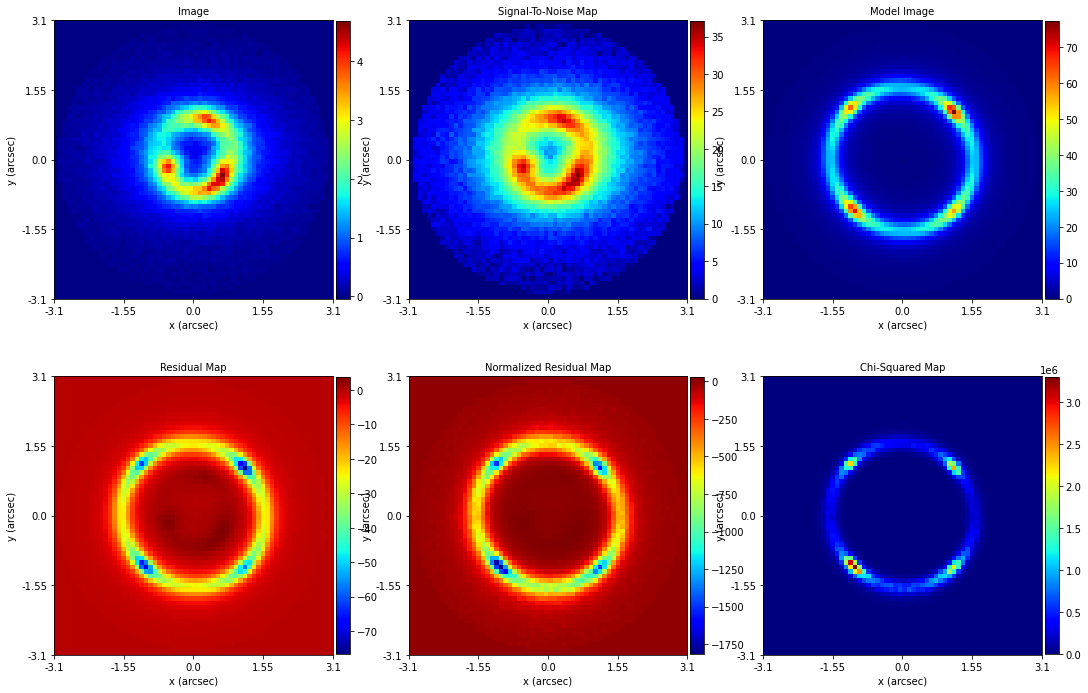

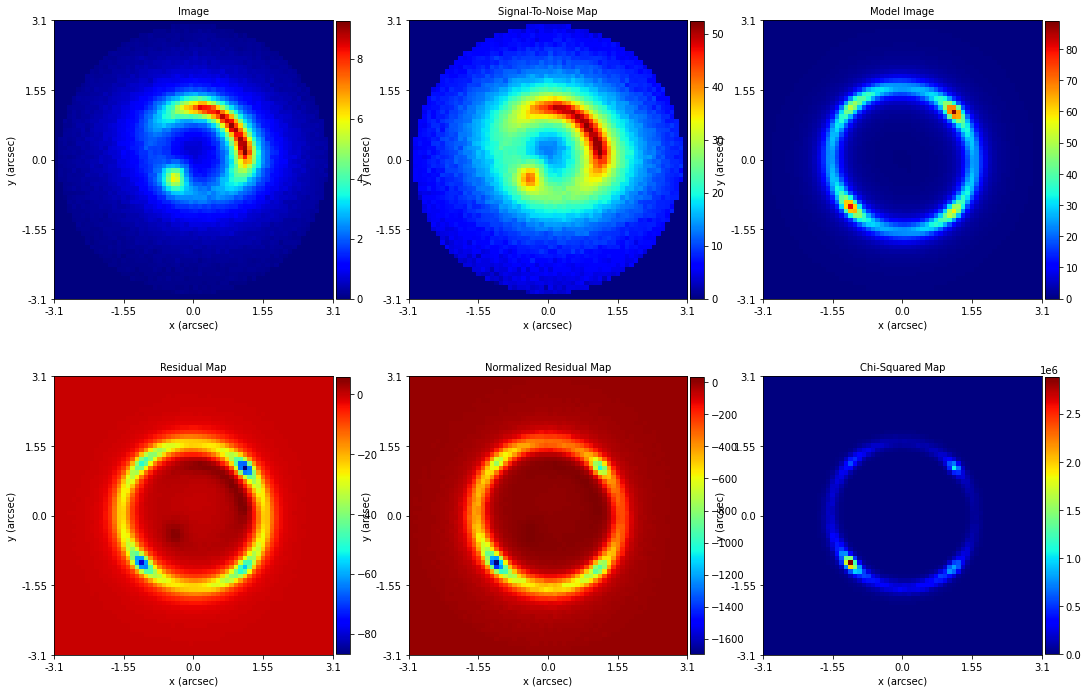

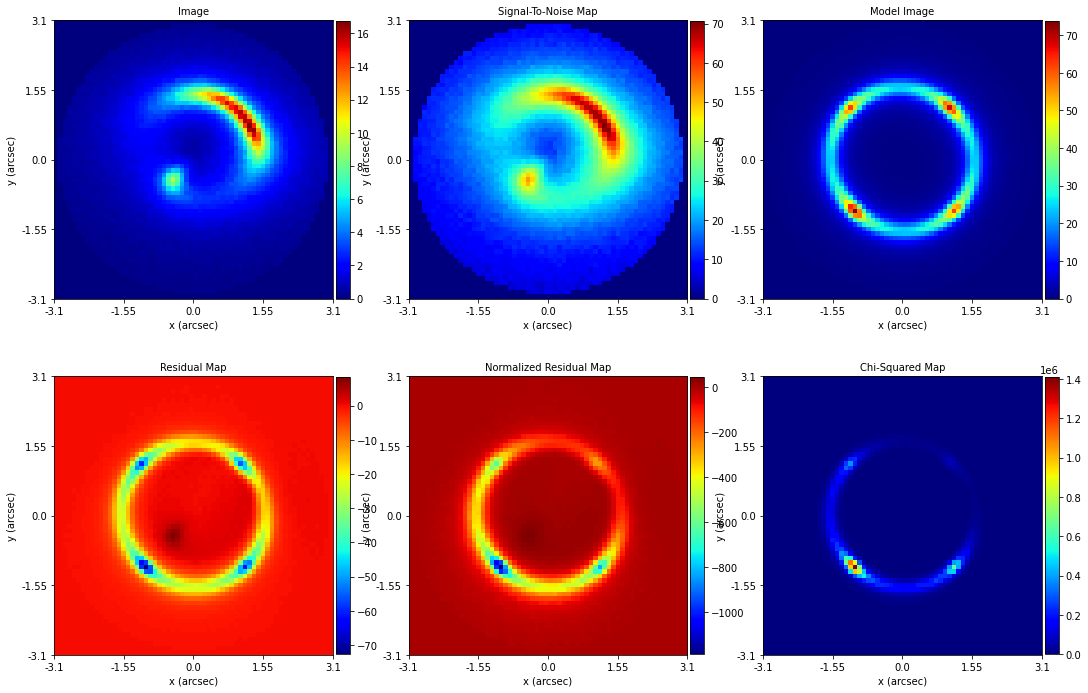

In [9]:


def plot_fit(agg_obj):

    imaging = al.agg.imaging_from_agg_obj(agg_obj=agg_obj)
    tracer = al.agg.tracer_from_agg_obj(agg_obj=agg_obj)

    return al.FitImaging(imaging=imaging, tracer=tracer)


fit_gen = agg.map(func=make_fit_generator)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

Of course, we also provide a convenience method to directly make the Imaging and FitImaging generators!

mass_sie__source_sersic__0
mass_sie__source_sersic__1
mass_sie__source_sersic__2


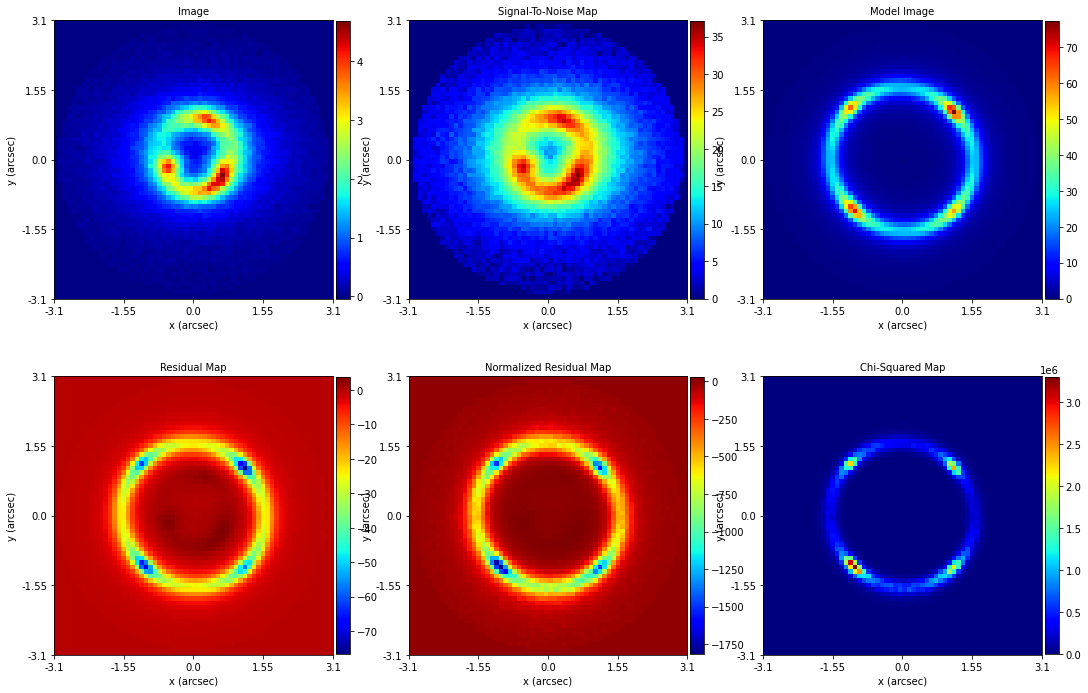

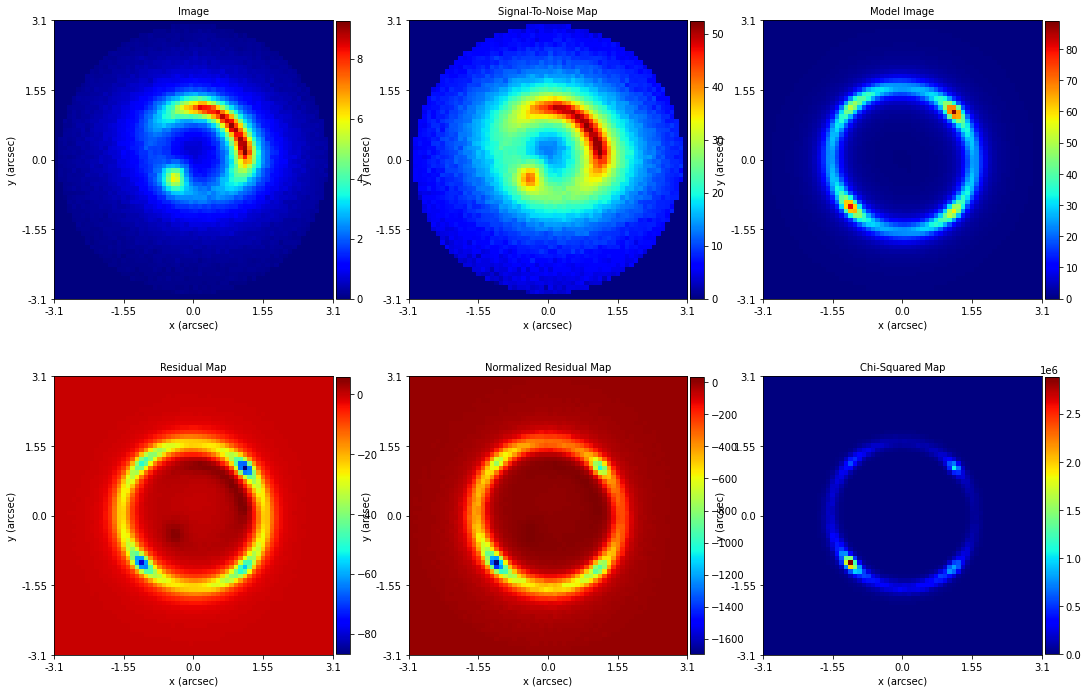

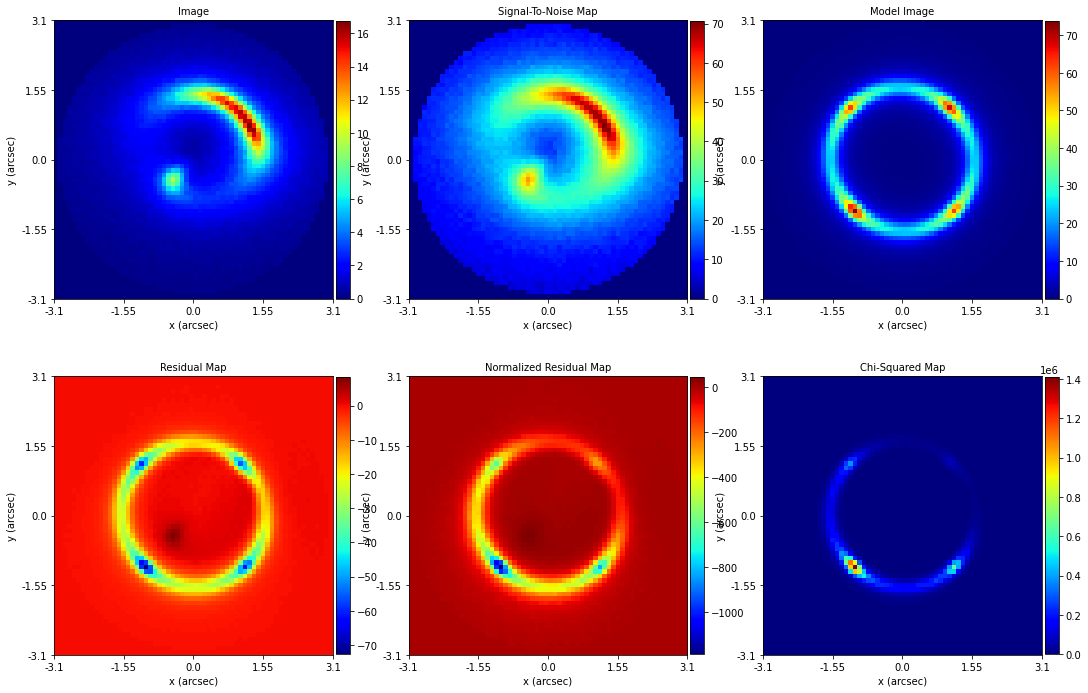

In [10]:
imaging_gen = al.agg.Imaging(aggregator=agg)

for imaging in imaging_gen:
    print(imaging.name)

fit_gen = al.agg.FitImaging(aggregator=agg)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

This convenience method goes one step further. By default, it uses the `SettingsImaging`, `SettingsPixelization`
and `SettingsInversion` used by the analysis. 

However, we can change these settings such that the model-fit is performed differently. For example, what if I wanted 
to see how the fit looks where the `Grid2D`'s `sub_size` is 4 (instead of the value of 2 that was used)? Or where 
the `Pixelization` didn`t use a border? You can do this by passing settings objects to the method, which overwrite 
the ones used by the analysis.

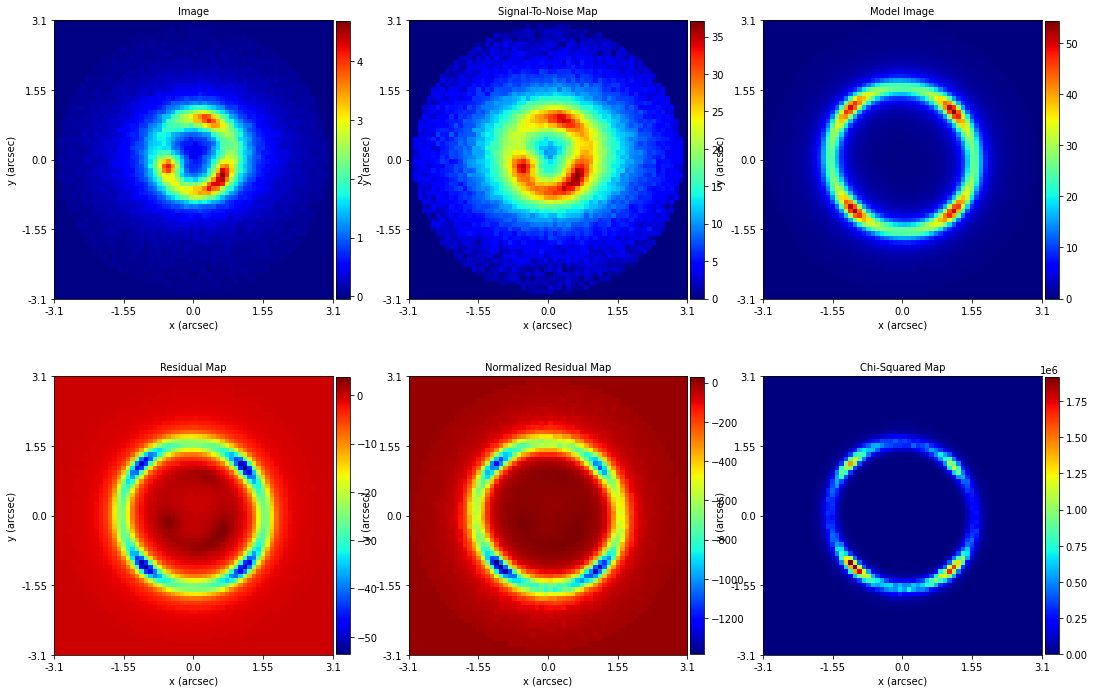

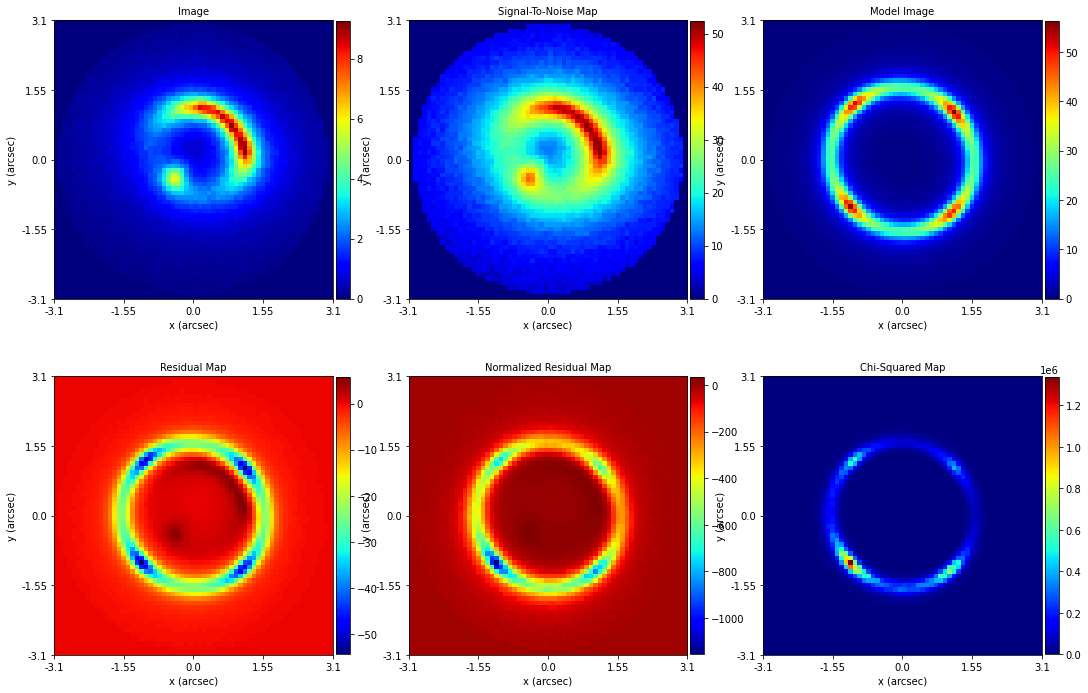

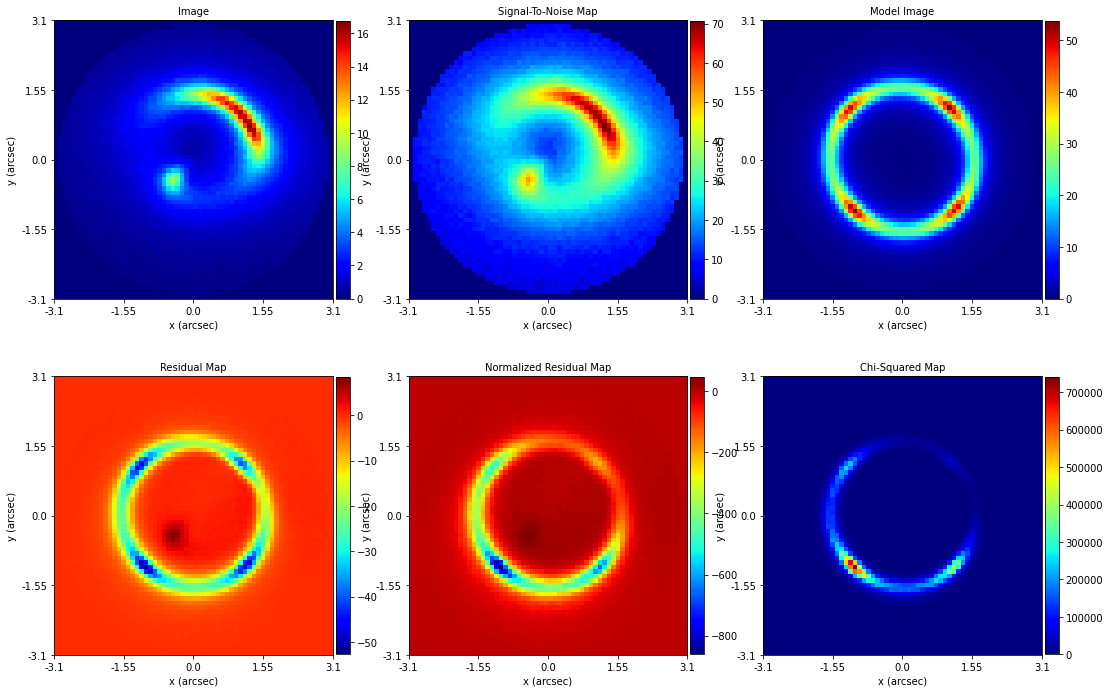

In [11]:
settings_imaging = al.SettingsImaging(sub_size=4)

imaging_gen = al.agg.Imaging(aggregator=agg, settings_imaging=settings_imaging)

settings_pixelization = al.SettingsPixelization(use_border=False)

fit_gen = al.agg.FitImaging(
    aggregator=agg,
    settings_imaging=settings_imaging,
    settings_pixelization=settings_pixelization,
)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

The benefit of inspecting fits using the aggregator, rather than the files outputs to the hard-disk, is that we can 
customize the plots using the PyAutoLens mat_plot_2d.

Below, we create a new function to apply as a generator to do this. However, we use a convenience method available 
in the PyAutoLens aggregator package to set up the fit.

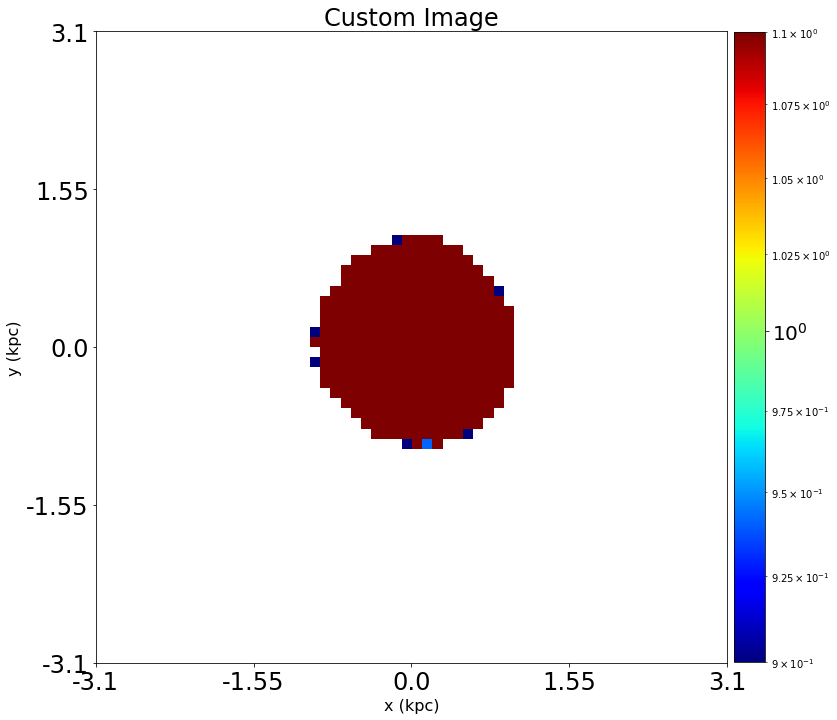

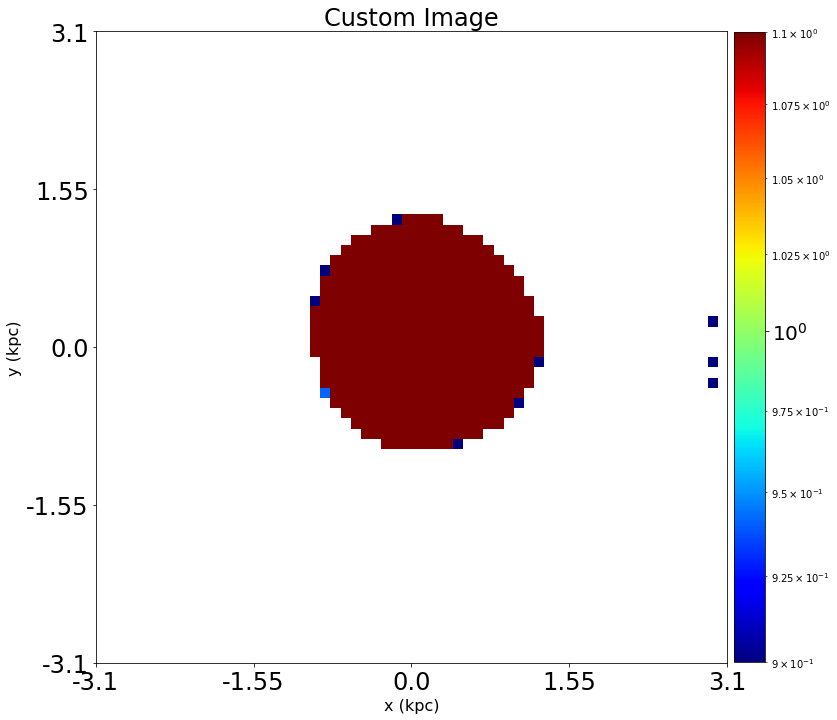

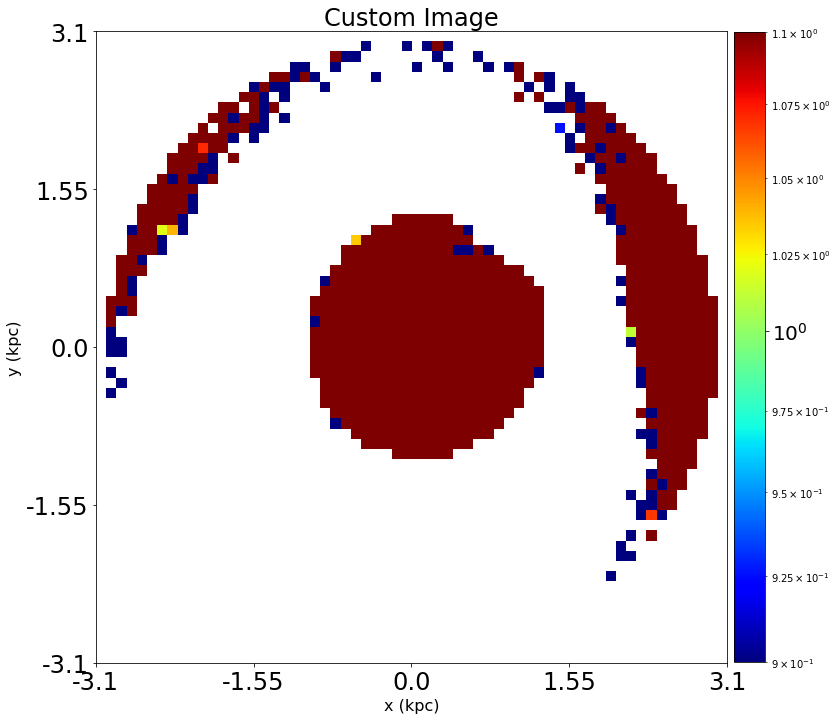

In [12]:
fit_gen = al.agg.FitImaging(aggregator=agg)

for fit in fit_gen:

    mat_plot_2d = aplt.MatPlot2D(
        figure=aplt.Figure(figsize=(12, 12)),
        title=aplt.Title(label="Custom Image", fontsize=24),
        yticks=aplt.YTicks(fontsize=24),
        xticks=aplt.XTicks(fontsize=24),
        cmap=aplt.Cmap(norm="log", vmax=1.0, vmin=1.0),
        colorbar_tickparams=aplt.ColorbarTickParams(labelsize=20),
        units=aplt.Units(in_kpc=True),
    )

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, mat_plot_2d=mat_plot_2d)
    fit_imaging_plotter.figures_2d(normalized_residual_map=True)

Making this plot for a paper? You can output it to hard disk.

In [13]:
fit_gen = al.agg.FitImaging(aggregator=agg)

for fit in fit_gen:

    mat_plot_2d = aplt.MatPlot2D(
        title=aplt.Title(label="Hey"),
        output=aplt.Output(
            path=path.join("output", "path", "of", "file"),
            filename="publication",
            format="png",
        ),
    )

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, mat_plot_2d=mat_plot_2d)
    fit_imaging_plotter.figures_2d(normalized_residual_map=True)

Finished.